In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Навчання рекурентних нейронних мереж LSTM i GRU засобами TensorFlow для прогнозування часового ряду
Мета роботи:
- Виконати довгострокове прогнозування часового ряду на основi глибоких ре- курентних нейронних мереж (RNN) LSTM i GRU.
- Дослiдити, чи пiдвищиться якiсть прогнозування шляхом включення шарiв з дропаутами мiж рекурентними шарами глибокої моделi RNN.
- Виконати довгострокове прогнозування часового ряду на основi глибокої моделi зi згортковими шарами conv1D та шарами пулiнгу max_pool1D.

## Хiд виконання роботи:
### Пiдготувати початковi часовi ряди. Розбити їх на навчальний i тестовий набори у спiввiдношеннi 1:3, вiдповiдно.

### Dataset: Google stock price
### Link to dataset: kaggle.com/datasets/rahulsah06/gooogle-stock-price?resource=download

In [2]:
TRAIN_DS_PATH = './data/Google_Stock_Price_Train.csv' 
TEST_DS_PATH = './data/Google_Stock_Price_Test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DS_PATH)
test_df = pd.read_csv(TEST_DS_PATH)
data = pd.concat([train_df, test_df])

In [4]:
def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df['Close'] = df['Close'].apply(lambda x : str(x).replace(',', '')).astype('float32')
    df.set_index('Date', inplace=True)
    df = df.sort_index(ascending=True)
    return df

In [5]:
data = preprocess_data(data)
data.sample(5)

Open    High     Low       Close     Volume
Date                                                     
2016-08-30  769.33  774.47  766.84  769.090027  1,130,000
2014-04-01  557.18  566.89  557.18  565.609985      7,900
2015-03-09  565.31  568.71  561.99  567.289978  1,062,100
2015-05-08  536.65  541.15  525.00  538.219971  1,527,600
2015-10-27  707.38  713.62  704.55  708.489990  2,245,800

In [6]:
data.describe()

Open         High          Low        Close
count  1278.000000  1278.000000  1278.000000  1278.000000
mean    537.994906   542.168897   533.278803   714.160034
std     154.508365   155.582501   153.174011   163.892410
min     279.120000   281.210000   277.220000   491.200012
25%     406.037500   408.230000   403.335000   578.412506
50%     538.395000   542.330000   534.355000   698.150024
75%     668.862500   677.705000   662.190000   785.572479
max     837.810000   841.950000   827.010000  1216.829956

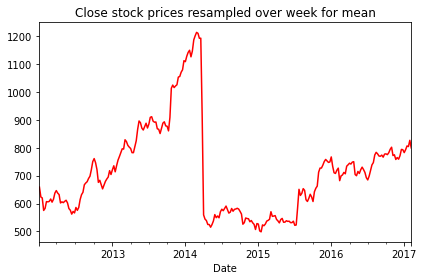

In [30]:
data.Close.resample('W').mean().plot(title='Close stock prices resampled over week for mean', color='red')
plt.tight_layout()
plt.show()

In [8]:
data = data[['Close']]
data = data.resample('W').mean()

In [9]:
data

Close
Date                  
2012-01-08  658.872498
2012-01-15  623.528015
2012-01-22  620.062500
2012-01-29  575.223999
2012-02-05  582.416016
...                ...
2017-01-08  793.302490
2017-01-15  806.718018
2017-01-22  804.467529
2017-01-29  826.862000
2017-02-05  799.554993

[266 rows x 1 columns]

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def create_train_test_sample(
    data, 
    n_time_steps = 5 , 
    train_test_split = 2/3
):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data.values)
    supervised = series_to_supervised(scaled, 5, 1)

    train = supervised.values[:int(supervised.shape[0] * train_test_split), :]
    test = supervised.values[int(supervised.shape[0] * train_test_split):, :]

    X_train, X_test, y_train, y_test = train[:, :-1], test[:, :-1], train[:, -1], test[:, -1]
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = create_train_test_sample(data)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(174, 1, 5) (87, 1, 5) (174,) (87,)


## Побудувати першу модель, використовуючи один шар базових рекурентних нейронiв, та аналогiчнi моделi iз одним шаром комiрок LSTM i GRU. Навчити цi три моделi на навчальних даних. Використати функцiю втрат Mean Squared Error (MSE). Побудувати графiки значень функцiї втрат залежно вiд кiлькостi епох на навчальнiй i тестовiй множинах.

In [12]:
rnn_layers = {
    'simple_rnn': tf.keras.layers.SimpleRNN,
    'lstm': tf.keras.layers.LSTM,
    'gru': tf.keras.layers.GRU
}

def build_model(layer_name, units):
    model = tf.keras.Sequential()
    rnn_layer = rnn_layers[layer_name](units, activation='relu')
    model.add(rnn_layer),
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mae')
    return model

def train_model(model, n_epochs):
    history = model.fit(X_train, 
                        y_train,
                        epochs=n_epochs,
                        validation_data=(X_test, y_test),
                        verbose = False)
    return history

def plot_loss(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model_name + ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'test loss'])
    plt.show()

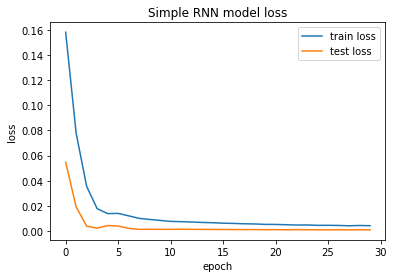

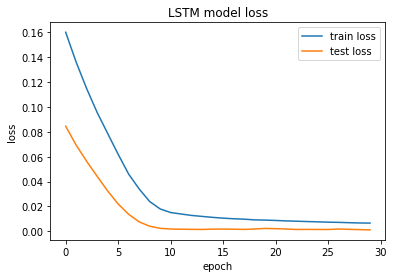

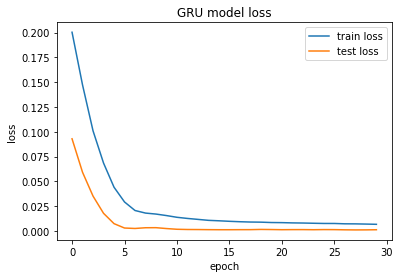

In [13]:
models = {
    'Simple RNN': build_model('simple_rnn', 100),
    'LSTM': build_model('lstm', 100),
    'GRU': build_model('gru', 100)
}

for model_name, model in models.items():
    model_history = train_model(model, 30)
    plot_loss(model_history, model_name)

## Побудувати прогнози на тестовому наборi даних. Оцiнити якiсть прогнозiв на тестовому наборi, використовуючи RMSE, MAE та MAPE.

In [14]:
def evaluate_model(model, model_name, X_test, y_test, print_metrics = False):
    y_pred = model.predict(X_test, verbose = False)
    
    rmse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
    
    if print_metrics:
        print(f'''
        Model name: {model_name}
            RMSE: {rmse},
            MAE: {mae},
            MAPE: {mape}
        ''')
    return (rmse, mae, mape)

In [15]:
for model_name, model in models.items():
    evaluate_model(model, model_name, X_test, y_test, True)


        Model name: Simple RNN
            RMSE: 0.0007949303835630417,
            MAE: 0.01961110718548298,
            MAPE: 0.09200658649206161
        

        Model name: LSTM
            RMSE: 0.0011305039515718818,
            MAE: 0.026667745783925056,
            MAPE: 0.13227787613868713
        

        Model name: GRU
            RMSE: 0.001295409514568746,
            MAE: 0.027881620451807976,
            MAPE: 0.11877545714378357
        


## Вiдобразити графiки реальних даних та прогнозiв на однiй координатнiй вiсi (окремо по кожнiй моделi).

In [16]:
def plot_true_predict_data(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test, verbose=False)
    
    plt.figure(figsize=(10,6))
    plt.plot(y_test)
    plt.plot(y_pred)
    plt.title(model_name + 'true vs predicted labels')
    plt.legend(['True labels', 'Predicted labels'])
    plt.show()

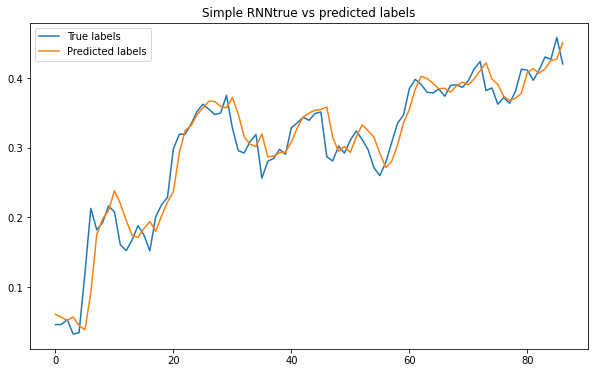

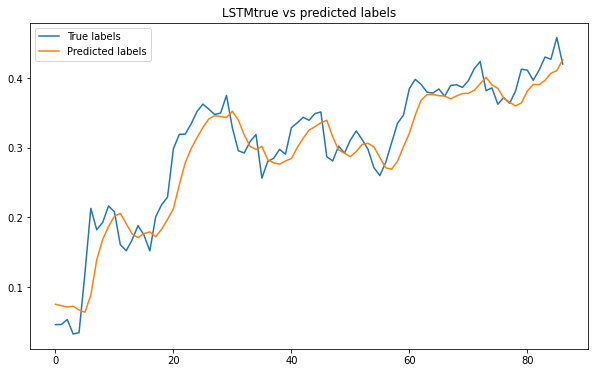

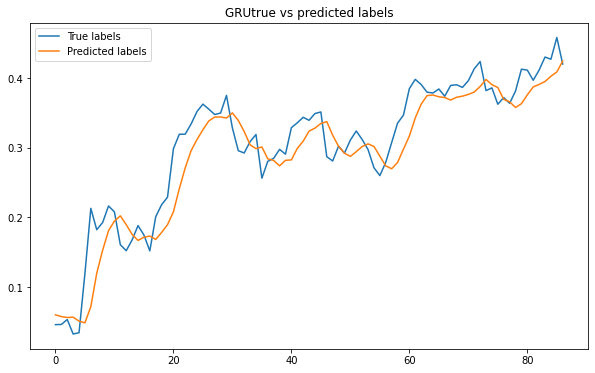

In [17]:
for model_name, model in models.items():
    plot_true_predict_data(model, model_name, X_test, y_test)

## First impressions: quite a good forecast. The only thing worth noting is a slight shift to the right

## Спробувати пiдiбрати кiлькiсть нейронiв у рекурентному шарi, кiлькiсть часових крокiв, а також кiлькiсть епох i розмiр батчу, щоб покращити якiсть прогнозiв.

In [18]:
time_steps = [3, 5, 6]
batch_sizes = [8, 16, 32]
n_units = [50, 100, 200]
n_epochs = [5, 20, 50]

def get_params(time_steps, batch_size, n_units, n_epochs):
    return {
        'time_steps': time_steps,
        'batch_size': batch_size,
        'n_units': n_units,
        'n_epochs': n_epochs
    }

params_list = [get_params(i, j, k, m) for i in time_steps for j in batch_sizes for k in n_units for m in n_epochs]

def train_hyperparams_and_return_best_ones(rnn_layer, params_list, best_model_metric):
    results_list = []
    for params in params_list:
        X_train, X_test, y_train, y_test = create_train_test_sample(data, params['time_steps'])
        model = build_model(rnn_layer, params['n_units'])
        history = model.fit(X_train, 
                            y_train,
                            epochs=params['n_epochs'],
                            batch_size=params['batch_size'],
                            validation_data=(X_test, y_test),
                            verbose = False)
        rmse, mae, mape = evaluate_model(model, 'dummy', X_test, y_test)
        result_part = [
            params['time_steps'],
            params['batch_size'],
            params['n_units'],
            params['n_epochs'],
            rmse,
            mae,
            mape
        ]
        results_list.append(result_part)
    results_df = pd.DataFrame(results_list,
                              columns=['time_steps', 'batch_size', 'n_units', 'n_epochs', 'rmse', 'mae', 'mape'])
    best_df = results_df.sort_values(by=best_model_metric, ascending=True).head(5)
    return best_df 

In [19]:
print('Simple RNN model hyperparameters search')
train_hyperparams_and_return_best_ones('simple_rnn', params_list, 'mae')

Simple RNN model hyperparameters search


time_steps  batch_size  n_units  n_epochs      rmse       mae      mape
61           6           8      200        20  0.000720  0.018975  0.081956
14           3          16      100        50  0.000744  0.019031  0.083506
50           5          32      100        50  0.000737  0.019164  0.086386
16           3          16      200        20  0.000749  0.019213  0.085222
41           5          16      100        50  0.000719  0.019304  0.086574

In [20]:
print('LSTM model hyperparameters search')
train_hyperparams_and_return_best_ones('lstm', params_list, 'mae')

LSTM model hyperparameters search


time_steps  batch_size  n_units  n_epochs      rmse       mae      mape
17           3          16      200        50  0.000787  0.019757  0.092189
44           5          16      200        50  0.000760  0.019768  0.092369
68           6          16      100        50  0.000801  0.020013  0.096980
32           5           8      100        50  0.000819  0.020427  0.087846
71           6          16      200        50  0.000795  0.020708  0.091886

In [21]:
print('GRU model hyperparameters search')
train_hyperparams_and_return_best_ones('gru', params_list, 'mae')

GRU model hyperparameters search


time_steps  batch_size  n_units  n_epochs      rmse       mae      mape
59           6           8      100        50  0.000723  0.018787  0.084037
41           5          16      100        50  0.000686  0.019446  0.099449
68           6          16      100        50  0.000769  0.019621  0.084919
34           5           8      200        20  0.000780  0.019649  0.086960
35           5           8      200        50  0.000758  0.019795  0.082551

## Порiвняти результати, отриманi моделями на основi базових рекурентних нейронiв, комiрок LSTM i GRU.

### Було проведено дослідження впиливу гіперпараметрів на результат мережі. 
### В результаті можна з впевненістю сказати, що всі моделі дали найкращі результати при використанні максимальної кількості часових кроків = 3, 5 або 6 та з маленьким розміром батчу.
### Крім того, варто зазначити, що практично всі моделі дали найкращий результат при навчанні в 50 епох. Можна зробити припущення, що моделі можна навчати ще і що вони не перенавчаються. 
### Загалом, можна з впевненістю зазначити, що підбір гіперпараметрів допоміг покращити результат.

### Якщо порівнювати моделі з різними шарами між собою, то за метрикою MAE лідером є мережа з шаром GRU, але дуже поруч з дуже схожим результатом розташувалась і мережа з шаром Simple_RNN. Дещо гірший результат показала мережа з шаром LSTM.

### --------------------------------------------------

## Побудувати i навчити глибоку модель з декiлькома рекурентними шарами LSTM, а також глибоку модель з декiлькома шарами GRU. Додати дропаути мiж рекурентними шарами цих моделей, а саме, спробувати застосувати дропаут до входiв кожного шару, виходiв та станiв кожного шару. Зробити висновки щодо якостi прогнозу на основi глибоких моделей RNN i моделей RNN з дропаутами.

In [22]:
## далі використовуємо значення time_steps найкращої моделі, тобто 5
X_train, X_test, y_train, y_test = create_train_test_sample(data)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(174, 1, 5) (87, 1, 5) (174,) (87,)


In [23]:
def build_deep_model(layer_name, dropout_value = 0):
    model = tf.keras.Sequential()
    
    rnn_layer = rnn_layers[layer_name]
    model.add(rnn_layer(64, 
                        activation='relu',
                        recurrent_dropout=dropout_value,
                        dropout=dropout_value,
                        return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_value))
    model.add(rnn_layer(32, 
                        activation='relu',
                        recurrent_dropout=dropout_value,
                        dropout=dropout_value,
                        return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_value))
    model.add(rnn_layer(16, 
                        activation='relu',
                        recurrent_dropout=dropout_value,
                        dropout=dropout_value,
                        return_sequences=False))
    model.add(tf.keras.layers.Dropout(dropout_value))
    
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mae')
    return model

In [24]:
deep_models = {
    'LSTM without dropout': build_deep_model('lstm', dropout_value = 0),
    'GRU without dropout': build_deep_model('gru', dropout_value = 0),
    'LSTM witk dropout': build_deep_model('lstm', dropout_value = 0.2),
    'GRU with dropout': build_deep_model('gru', dropout_value = 0.2)
}


----------------- LSTM without dropout --------------------



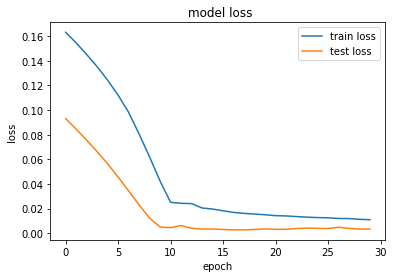


        Model name: 
            RMSE: 0.0034748332109302282,
            MAE: 0.05230744555592537,
            MAPE: 0.2504717707633972
        


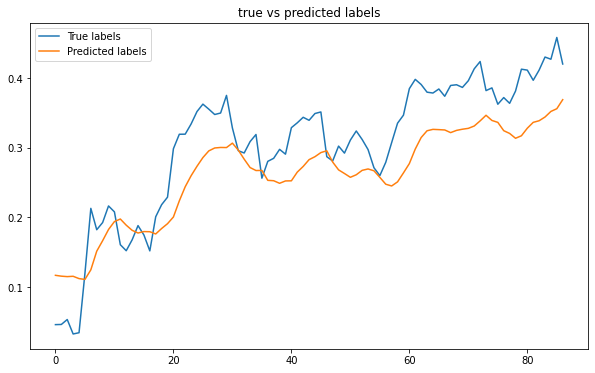


----------------- GRU without dropout --------------------



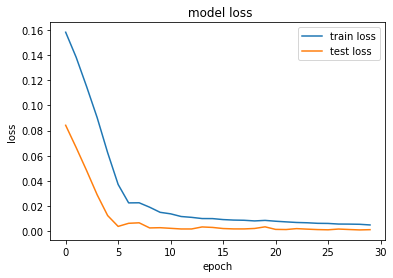


        Model name: 
            RMSE: 0.0010871751001104712,
            MAE: 0.026319807395339012,
            MAPE: 0.11604316532611847
        


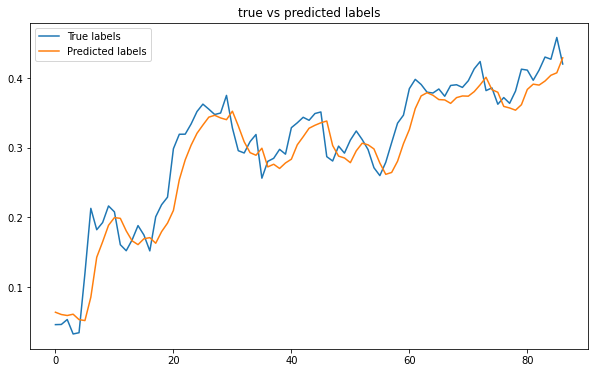


----------------- LSTM witk dropout --------------------



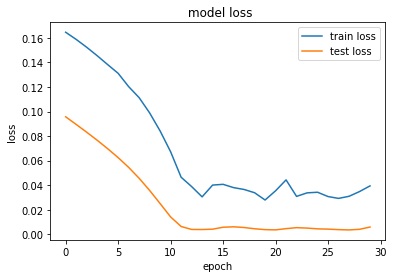


        Model name: 
            RMSE: 0.005880593787878752,
            MAE: 0.06665991991758347,
            MAPE: 0.3621312379837036
        


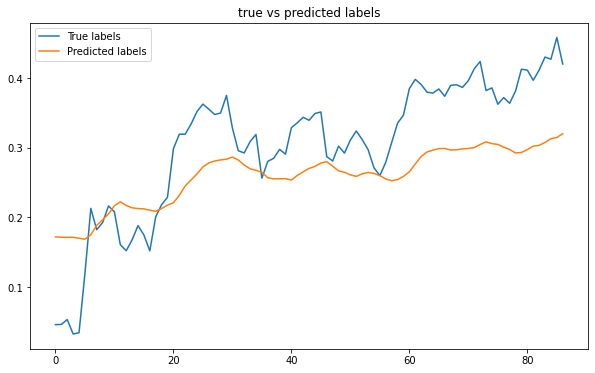


----------------- GRU with dropout --------------------



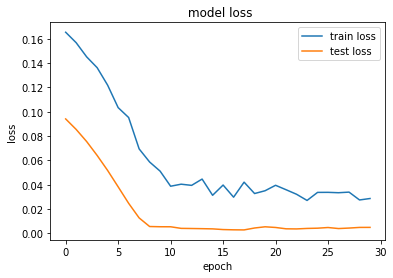


        Model name: 
            RMSE: 0.004904184024780989,
            MAE: 0.06178433820605278,
            MAPE: 0.2996342182159424
        


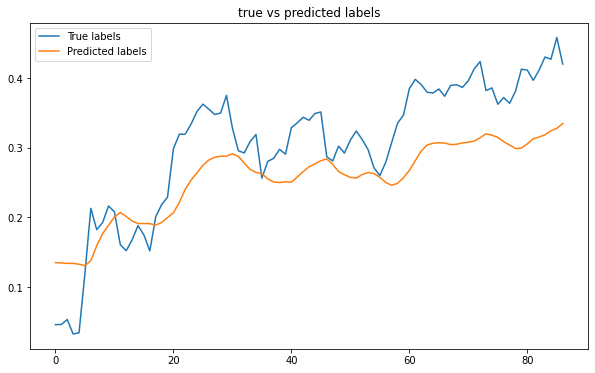

In [25]:
for model_name, model in deep_models.items():
    print(f'\n----------------- {model_name} --------------------\n')
    model_history = train_model(model, 30)
    plot_loss(model_history, '')
    evaluate_model(model, '', X_test, y_test, True)
    plot_true_predict_data(model, '', X_test, y_test)

### Загалом, більш глибокі моделі показали себе гірше за прості. Використання dropuot погіршує якість навчання моделей. Найраще себе показала модель GRU без дропауту

## Побудувати i навчити глибоку модель зi згортковими шарами conv1D та шарами max_pool1D. Побудувати часткову автокореляцiйну функцiю ряду, який прогнозується, i перевiрити гiпотезу щодо присутностi автокореляцiї у цьому рядi. Згортковi шари, як вiдомо, є гарним способом дослiдження локальної структури даних.

In [26]:
def build_conv_deep_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=64,
                                     kernel_size=2,
                                     strides=2,
                                     activation='relu',
                                     padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, 
                                           padding='same'))
    model.add(tf.keras.layers.GRU(20, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mae')
    return model

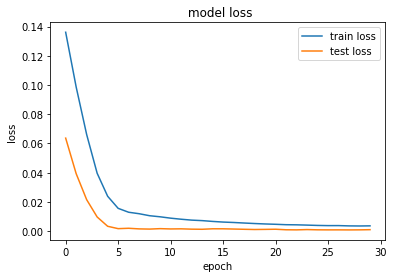


        Model name: 
            RMSE: 0.000971201341599226,
            MAE: 0.02454652450978756,
            MAPE: 0.10250747203826904
        


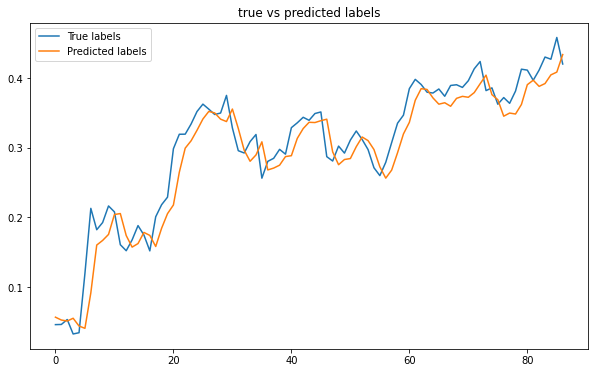

In [27]:
conv_deep_model = build_conv_deep_model()
model_history = train_model(conv_deep_model, 30)
plot_loss(model_history, '')
evaluate_model(conv_deep_model, '', X_test, y_test, True)
plot_true_predict_data(conv_deep_model, '', X_test, y_test)

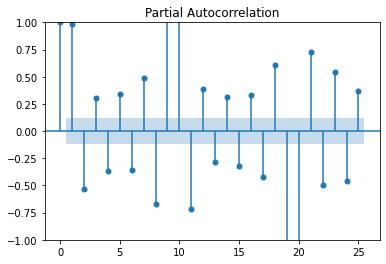

In [28]:
plot_pacf(data['Close'].resample('W').mean().dropna().values)
plt.show()

### У ряді присутня значна часткова автокореляція.

## Порiвняти всi моделi i обрати найкращу з них.

### Найраще за всіх показала себе проста модел з одним шаром GRU та наступними гіперпараметрами:
- time step: 6
- batch_size: 8 
- n_units: 100
- epoch: 50

### Результат найкращої моделі за метриками:
- RMSR: 0.000714
- MAE: 0.018664
- MAPE: 0.081049